# Using python to speedup the analysis of large datasets


In this case I want to integrate the human fetal atlas published by Braun with the de Faria data (the atlas was made from aborted children, so keep that in mind). The goal of this analysis is to find genes in the tumors that correlate with genes that are expressed at some stage of fetal development.

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
from __future__ import annotations
import anndata as ad
import warnings
warnings.filterwarnings("ignore")
import hdf5plugin

## Reading reference data

In [4]:

ref_data = ad.io.read_h5ad("/home/sofia/Projects/etmr/de Faria/snRNA/data/snrna_data_filt_so_sub_1_fixed_filt.h5ad")


## Reading fixed tumor data from de Faria paper

GSM8058157 	Human ETMR tumor, C19MC amplified, 1
GSM8058158 	Human ETMR tumor, C19MC amplified, 2
GSM8058159 	Human ETMR tumor, Dicer mutation, 1
GSM8058160 	Human ETMR tumor, C19MC amplified, 3
GSM8058161 	Human ETMR tumor, C19MC amplified, 4
GSM8058162 	Human ETMR tumor, C19MC amplified, 5
GSM8058163 	Human ETMR tumor, C19MC amplified, 6
GSM8058164 	Human ETMR tumor, C19MC amplified, 7
GSM8058165 	Human ETMR tumor, C19MC amplified, 8

 	

    de Faria FW, Riedel NC, Münter D, Interlandi M et al. ETMR stem-like state and chemo-resistance are supported by perivascular cells at single-cell resolution. Nat Commun 2025 Jun 25;16(1):5394. PMID: 40562749

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE254819

In [5]:
experiment_data = ad.io.read_h5ad("/home/sofia/Projects/etmr/de Faria/snRNA/data/snrna_data_filt_comvar.h5ad")


## Defining datasets on the same variables

## Plotting unintegrated data

In [6]:

# Dimensionality reduction and embedding
sc.pp.pca(ref_data)
# sc.pl.pca_variance_ratio(ref_data, n_pcs=50)
sc.pp.neighbors(ref_data, n_neighbors=10, n_pcs=50)
sc.tl.umap(ref_data)

In [ ]:
ref_data.obs

orig.ident  nCount_RNA  nFeature_RNA   Age  \
10X89_1:ACGCAGCAGTGGTAAT       10X89      5301.0          2512   8.0   
10X89_1:ACTTACTTCAACACAC       10X89      5291.0          2685   8.0   
10X89_1:ATCGAGTAGAATGTTG       10X89      3927.0          2216   8.0   
10X89_1:CCGGTAGAGACAATAC       10X89      4472.0          2277   8.0   
10X89_1:CGCTGGAAGCCACCTG       10X89      3941.0          2208   8.0   
...                              ...         ...           ...   ...   
10X211_5:TCTGGCTAGGAGTATT     10X211     22017.0          6494  11.5   
10X211_5:TTCAATCCACTTTATC     10X211     22350.0          6405  11.5   
10X211_5:TTCGGTCCATTCTGTT     10X211     18647.0          6295  11.5   
10X211_5:TTGCTGCGTACCTTCC     10X211     17961.0          6064  11.5   
10X254_4:GTAGATCGTGCCGTTG     10X254      2470.0          1462  14.0   

                             CellClass Chemistry         Region   Subregion  \
10X89_1:ACGCAGCAGTGGTAAT     Glioblast        v2  Telencephalon      Cortex   
10X89_1:ACTTACTTCAACACAC     Glioblast        v2  Telencephalon      Cortex   
10X89_1:ATCGAGTAGAATGTTG     Glioblast        v2  Telencephalon      Cortex   
10X89_1:CCGGTAGAGACAATAC     Glioblast        v2  Telencephalon      Cortex   
10X89_1:CGCTGGAAGCCACCTG     Glioblast        v2  Telencephalon      Cortex   
...                                ...       ...            ...         ...   
10X211_5:TCTGGCTAGGAGTATT  Radial glia        v3      Forebrain   Subcortex   
10X211_5:TTCAATCCACTTTATC  Radial glia        v3      Forebrain   Subcortex   
10X211_5:TTCGGTCCATTCTGTT  Radial glia        v3      Forebrain   Subcortex   
10X211_5:TTGCTGCGTACCTTCC  Radial glia        v3      Forebrain   Subcortex   
10X254_4:GTAGATCGTGCCGTTG  Radial glia        v3     Cerebellum  Cerebellum   

                          donor_id             dissection  ...  \
10X89_1:ACGCAGCAGTGGTAAT   BRC2006                 Cortex  ...   
10X89_1:ACTTACTTCAACACAC   BRC2006                 Cortex  ...   
10X89_1:ATCGAGTAGAATGTTG   BRC2006                 Cortex  ...   
10X89_1:CCGGTAGAGACAATAC   BRC2006                 Cortex  ...   
10X89_1:CGCTGGAAGCCACCTG   BRC2006                 Cortex  ...   
...                            ...                    ...  ...   
10X211_5:TCTGGCTAGGAGTATT  XDD:358  Subcortical forebrain  ...   
10X211_5:TTCAATCCACTTTATC  XDD:358  Subcortical forebrain  ...   
10X211_5:TTCGGTCCATTCTGTT  XDD:358  Subcortical forebrain  ...   
10X211_5:TTGCTGCGTACCTTCC  XDD:358  Subcortical forebrain  ...   
10X254_4:GTAGATCGTGCCGTTG  XDD:385             Cerebellum  ...   

                           fraction_unspliced  cell_cycle_score  total_genes  \
10X89_1:ACGCAGCAGTGGTAAT             0.233352          0.003962         2512   
10X89_1:ACTTACTTCAACACAC             0.318087          0.004725         2685   
10X89_1:ATCGAGTAGAATGTTG             0.284696          0.009422         2216   
10X89_1:CCGGTAGAGACAATAC             0.251342          0.003131         2277   
10X89_1:CGCTGGAAGCCACCTG             0.320223          0.004314         2208   
...                                       ...               ...          ...   
10X211_5:TCTGGCTAGGAGTATT            0.385929          0.002089         6494   
10X211_5:TTCAATCCACTTTATC            0.545280          0.001700         6405   
10X211_5:TTCGGTCCATTCTGTT            0.392342          0.001770         6295   
10X211_5:TTGCTGCGTACCTTCC            0.445020          0.003508         6064   
10X254_4:GTAGATCGTGCCGTTG            0.427935          0.013765         1462   

                           total_UMIs  sample_id cluster_id  \
10X89_1:ACGCAGCAGTGGTAAT         5301    10X89_1        187   
10X89_1:ACTTACTTCAACACAC         5291    10X89_1        187   
10X89_1:ATCGAGTAGAATGTTG         3927    10X89_1        187   
10X89_1:CCGGTAGAGACAATAC         4472    10X89_1        187   
10X89_1:CGCTGGAAGCCACCTG         3941    10X89_1        185   
...                               ...        ...        ...   
10X211_5:TCTGGCTA

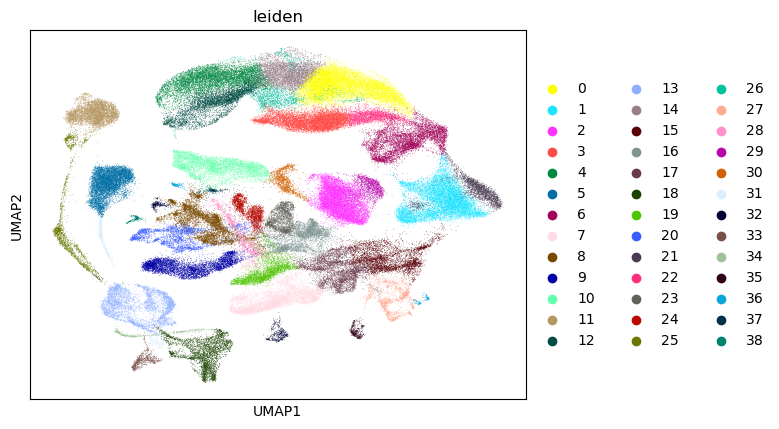

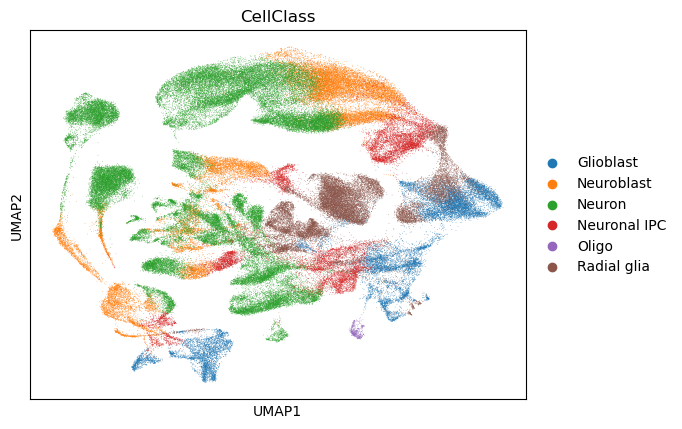

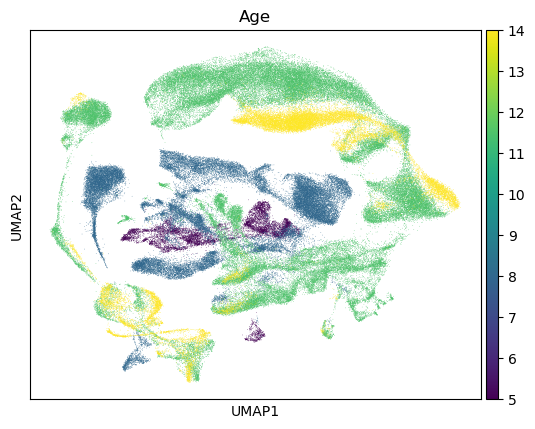

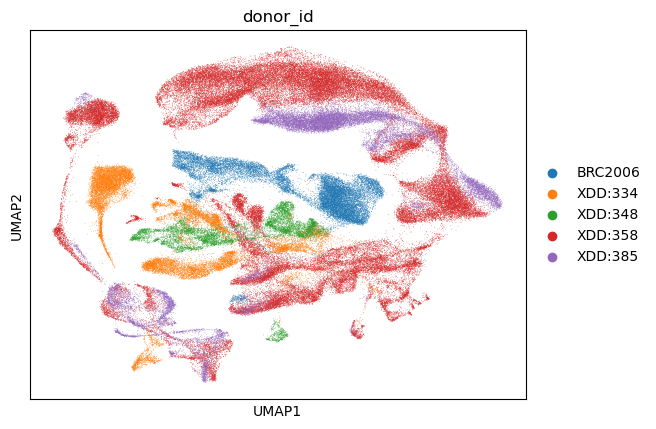

orig.ident  nCount_RNA  nFeature_RNA   Age  \
10X89_1:ACGCAGCAGTGGTAAT       10X89      5301.0          2512   8.0   
10X89_1:ACTTACTTCAACACAC       10X89      5291.0          2685   8.0   
10X89_1:ATCGAGTAGAATGTTG       10X89      3927.0          2216   8.0   
10X89_1:CCGGTAGAGACAATAC       10X89      4472.0          2277   8.0   
10X89_1:CGCTGGAAGCCACCTG       10X89      3941.0          2208   8.0   
...                              ...         ...           ...   ...   
10X211_5:TCTGGCTAGGAGTATT     10X211     22017.0          6494  11.5   
10X211_5:TTCAATCCACTTTATC     10X211     22350.0          6405  11.5   
10X211_5:TTCGGTCCATTCTGTT     10X211     18647.0          6295  11.5   
10X211_5:TTGCTGCGTACCTTCC     10X211     17961.0          6064  11.5   
10X254_4:GTAGATCGTGCCGTTG     10X254      2470.0          1462  14.0   

                             CellClass Chemistry         Region   Subregion  \
10X89_1:ACGCAGCAGTGGTAAT     Glioblast        v2  Telencephalon      Cortex   
10X89_1:ACTTACTTCAACACAC     Glioblast        v2  Telencephalon      Cortex   
10X89_1:ATCGAGTAGAATGTTG     Glioblast        v2  Telencephalon      Cortex   
10X89_1:CCGGTAGAGACAATAC     Glioblast        v2  Telencephalon      Cortex   
10X89_1:CGCTGGAAGCCACCTG     Glioblast        v2  Telencephalon      Cortex   
...                                ...       ...            ...         ...   
10X211_5:TCTGGCTAGGAGTATT  Radial glia        v3      Forebrain   Subcortex   
10X211_5:TTCAATCCACTTTATC  Radial glia        v3      Forebrain   Subcortex   
10X211_5:TTCGGTCCATTCTGTT  Radial glia        v3      Forebrain   Subcortex   
10X211_5:TTGCTGCGTACCTTCC  Radial glia        v3      Forebrain   Subcortex   
10X254_4:GTAGATCGTGCCGTTG  Radial glia        v3     Cerebellum  Cerebellum   

                          donor_id             dissection  ...  \
10X89_1:ACGCAGCAGTGGTAAT   BRC2006                 Cortex  ...   
10X89_1:ACTTACTTCAACACAC   BRC2006                 Cortex  ...   
10X89_1:ATCGAGTAGAATGTTG   BRC2006                 Cortex  ...   
10X89_1:CCGGTAGAGACAATAC   BRC2006                 Cortex  ...   
10X89_1:CGCTGGAAGCCACCTG   BRC2006                 Cortex  ...   
...                            ...                    ...  ...   
10X211_5:TCTGGCTAGGAGTATT  XDD:358  Subcortical forebrain  ...   
10X211_5:TTCAATCCACTTTATC  XDD:358  Subcortical forebrain  ...   
10X211_5:TTCGGTCCATTCTGTT  XDD:358  Subcortical forebrain  ...   
10X211_5:TTGCTGCGTACCTTCC  XDD:358  Subcortical forebrain  ...   
10X254_4:GTAGATCGTGCCGTTG  XDD:385             Cerebellum  ...   

                           cell_cycle_score  total_genes  total_UMIs  \
10X89_1:ACGCAGCAGTGGTAAT           0.003962         2512        5301   
10X89_1:ACTTACTTCAACACAC           0.004725         2685        5291   
10X89_1:ATCGAGTAGAATGTTG           0.009422         2216        3927   
10X89_1:CCGGTAGAGACAATAC           0.003131         2277        4472   
10X89_1:CGCTGGAAGCCACCTG           0.004314         2208        3941   
...                                     ...          ...         ...   
10X211_5:TCTGGCTAGGAGTATT          0.002089         6494       22017   
10X211_5:TTCAATCCACTTTATC          0.001700         6405       22350   
10X211_5:TTCGGTCCATTCTGTT          0.001770         6295       18647   
10X211_5:TTGCTGCGTACCTTCC          0.003508         6064       17961   
10X254_4:GTAGATCGTGCCGTTG          0.013765         1462        2470   

                           sample_id  cluster_id n_genes_by_counts  \
10X89_1:ACGCAGCAGTGGTAAT     10X89_1         187              2512   
10X89_1:ACTTACTTCAACACAC     10X89_1         187              2685   
10X89_1:ATCGAGTAGAATGTTG     10X89_1         187              2216   
10X89_1:CCGGTAGAGACAATAC     10X89_1         187              2277   
10X89_1:CGCTGGAAGCCACCTG     10X89_1         185              2208   
...                              ...         ...               ...   
10X211_5:TCTGGCTAGGAGTATT   10X211_5          55              64

In [ ]:
sc.tl.leiden(ref_data, resolution=1)
# experiment_data.obsm["X_umap"] = experiment_data.obsm["X_umap"]
sc.pl.umap(ref_data, color=["leiden"])
sc.pl.umap(ref_data, color=["CellClass"])
sc.pl.umap(ref_data, color=["Age"])
sc.pl.umap(ref_data, color=["donor_id"])


In [14]:
ref_data.obs


orig.ident  nCount_RNA  nFeature_RNA   Age  \
10X89_1:ACGCAGCAGTGGTAAT       10X89      5301.0          2512   8.0   
10X89_1:ACTTACTTCAACACAC       10X89      5291.0          2685   8.0   
10X89_1:ATCGAGTAGAATGTTG       10X89      3927.0          2216   8.0   
10X89_1:CCGGTAGAGACAATAC       10X89      4472.0          2277   8.0   
10X89_1:CGCTGGAAGCCACCTG       10X89      3941.0          2208   8.0   
...                              ...         ...           ...   ...   
10X211_5:TCTGGCTAGGAGTATT     10X211     22017.0          6494  11.5   
10X211_5:TTCAATCCACTTTATC     10X211     22350.0          6405  11.5   
10X211_5:TTCGGTCCATTCTGTT     10X211     18647.0          6295  11.5   
10X211_5:TTGCTGCGTACCTTCC     10X211     17961.0          6064  11.5   
10X254_4:GTAGATCGTGCCGTTG     10X254      2470.0          1462  14.0   

                             CellClass Chemistry         Region   Subregion  \
10X89_1:ACGCAGCAGTGGTAAT     Glioblast        v2  Telencephalon      Cortex   
10X89_1:ACTTACTTCAACACAC     Glioblast        v2  Telencephalon      Cortex   
10X89_1:ATCGAGTAGAATGTTG     Glioblast        v2  Telencephalon      Cortex   
10X89_1:CCGGTAGAGACAATAC     Glioblast        v2  Telencephalon      Cortex   
10X89_1:CGCTGGAAGCCACCTG     Glioblast        v2  Telencephalon      Cortex   
...                                ...       ...            ...         ...   
10X211_5:TCTGGCTAGGAGTATT  Radial glia        v3      Forebrain   Subcortex   
10X211_5:TTCAATCCACTTTATC  Radial glia        v3      Forebrain   Subcortex   
10X211_5:TTCGGTCCATTCTGTT  Radial glia        v3      Forebrain   Subcortex   
10X211_5:TTGCTGCGTACCTTCC  Radial glia        v3      Forebrain   Subcortex   
10X254_4:GTAGATCGTGCCGTTG  Radial glia        v3     Cerebellum  Cerebellum   

                          donor_id             dissection  ...  \
10X89_1:ACGCAGCAGTGGTAAT   BRC2006                 Cortex  ...   
10X89_1:ACTTACTTCAACACAC   BRC2006                 Cortex  ...   
10X89_1:ATCGAGTAGAATGTTG   BRC2006                 Cortex  ...   
10X89_1:CCGGTAGAGACAATAC   BRC2006                 Cortex  ...   
10X89_1:CGCTGGAAGCCACCTG   BRC2006                 Cortex  ...   
...                            ...                    ...  ...   
10X211_5:TCTGGCTAGGAGTATT  XDD:358  Subcortical forebrain  ...   
10X211_5:TTCAATCCACTTTATC  XDD:358  Subcortical forebrain  ...   
10X211_5:TTCGGTCCATTCTGTT  XDD:358  Subcortical forebrain  ...   
10X211_5:TTGCTGCGTACCTTCC  XDD:358  Subcortical forebrain  ...   
10X254_4:GTAGATCGTGCCGTTG  XDD:385             Cerebellum  ...   

                           cell_cycle_score  total_genes  total_UMIs  \
10X89_1:ACGCAGCAGTGGTAAT           0.003962         2512        5301   
10X89_1:ACTTACTTCAACACAC           0.004725         2685        5291   
10X89_1:ATCGAGTAGAATGTTG           0.009422         2216        3927   
10X89_1:CCGGTAGAGACAATAC           0.003131         2277        4472   
10X89_1:CGCTGGAAGCCACCTG           0.004314         2208        3941   
...                                     ...          ...         ...   
10X211_5:TCTGGCTAGGAGTATT          0.002089         6494       22017   
10X211_5:TTCAATCCACTTTATC          0.001700         6405       22350   
10X211_5:TTCGGTCCATTCTGTT          0.001770         6295       18647   
10X211_5:TTGCTGCGTACCTTCC          0.003508         6064       17961   
10X254_4:GTAGATCGTGCCGTTG          0.013765         1462        2470   

                           sample_id  cluster_id n_genes_by_counts  \
10X89_1:ACGCAGCAGTGGTAAT     10X89_1         187              2512   
10X89_1:ACTTACTTCAACACAC     10X89_1         187              2685   
10X89_1:ATCGAGTAGAATGTTG     10X89_1         187              2216   
10X89_1:CCGGTAGAGACAATAC     10X89_1         187              2277   
10X89_1:CGCTGGAAGCCACCTG     10X89_1         185              2208   
...                              ...         ...               ...   
10X211_5:TCTGGCTAGGAGTATT   10X211_5          55              64

In [18]:
print(ref_data.uns["leiden_colors"])
print(ref_data.uns["leiden"])

['#ffff00', '#1ce6ff', '#ff34ff', '#ff4a46', '#008941', '#006fa6', '#a30059', '#ffdbe5', '#7a4900', '#0000a6', '#63ffac', '#b79762', '#004d43', '#8fb0ff', '#997d87', '#5a0007', '#809693', '#6a3a4c', '#1b4400', '#4fc601', '#3b5dff', '#4a3b53', '#ff2f80', '#61615a', '#ba0900', '#6b7900', '#00c2a0', '#ffaa92', '#ff90c9', '#b903aa', '#d16100', '#ddefff', '#000035', '#7b4f4b', '#a1c299', '#300018', '#0aa6d8', '#013349', '#00846f']
{'params': {'resolution': 1, 'random_state': 0, 'n_iterations': -1}}


In [19]:
#I previously normalized everything the same way, so I can directly ingest

sc.tl.ingest(experiment_data, ref_data, obs=["leiden", "Age", "CellClass", "Region", "Subregion", "dissection"], embedding_method = "umap")

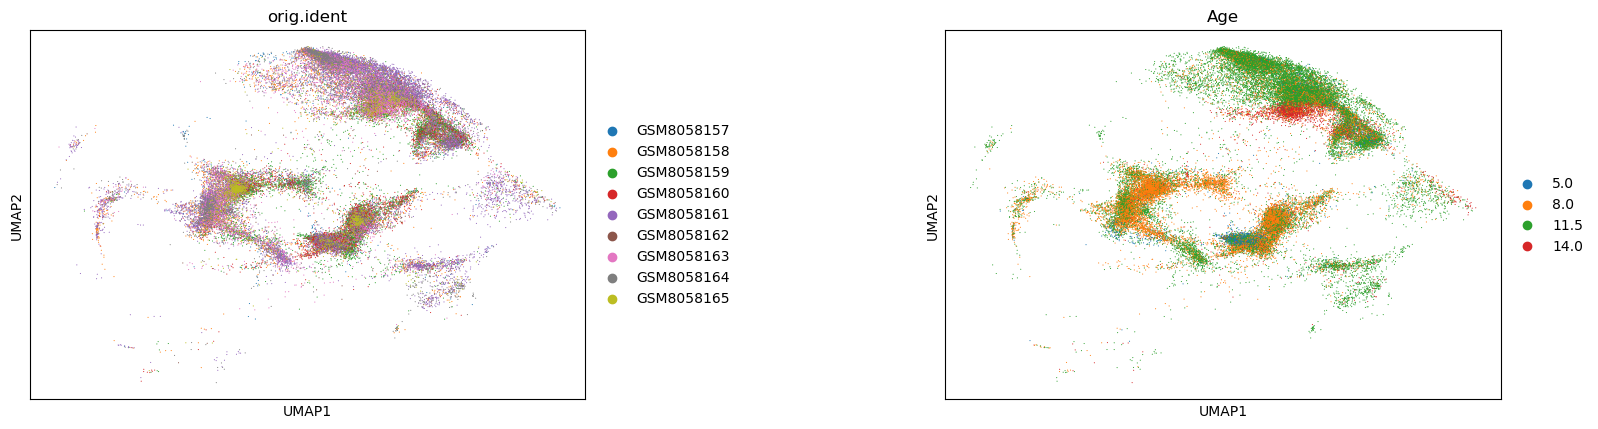

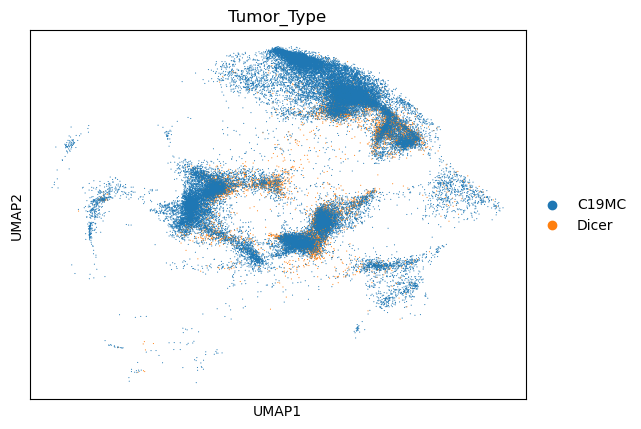

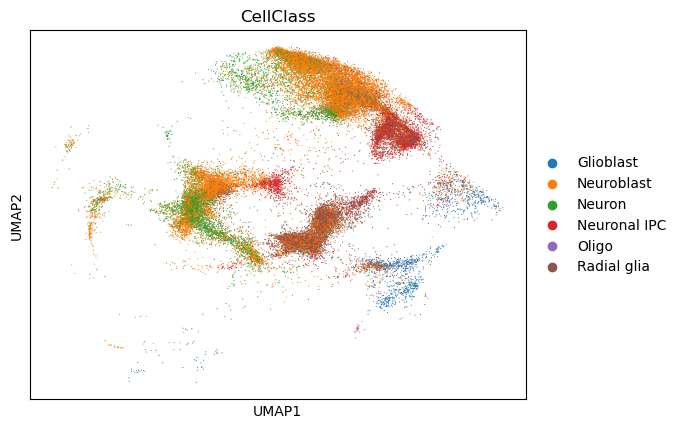

In [20]:

sc.pl.umap(experiment_data, color=["orig.ident","Age"], wspace=0.5 )
sc.pl.umap(experiment_data, color=["Tumor_Type"], wspace=0.5 )
sc.pl.umap(experiment_data, color=["CellClass"], wspace=0.5 )


In [22]:
all_data = ad.concat([ref_data, experiment_data], label="condition", keys=["ref", "etmr"])
all_data.obs["leiden"] = (
    all_data.obs["leiden"].astype("category").cat.reorder_categories(ref_data.obs["leiden"].cat.categories)
)
all_data.uns["leiden_colors"] = ref_data.uns["leiden_colors"]

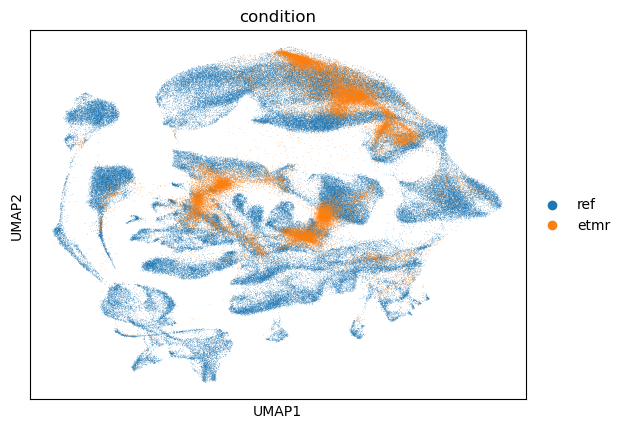

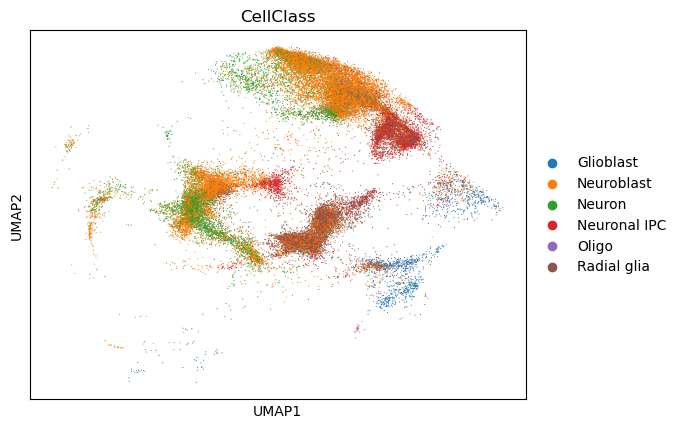

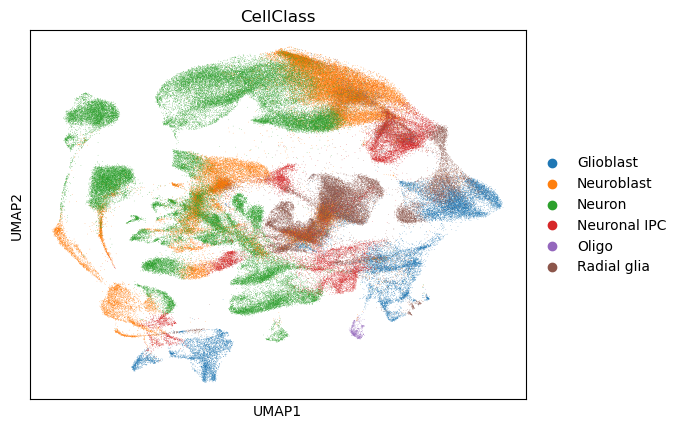

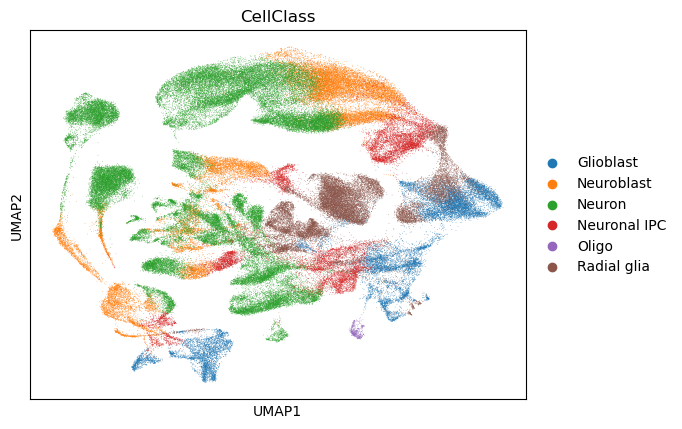

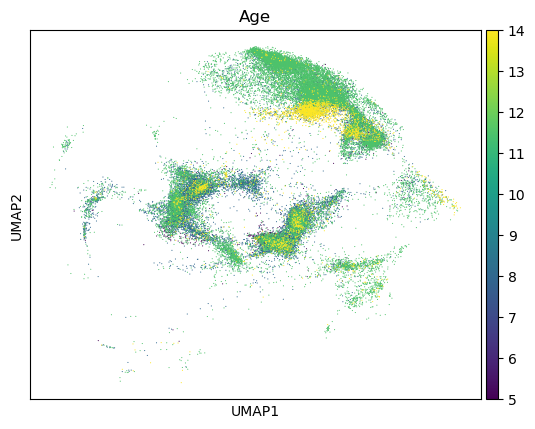

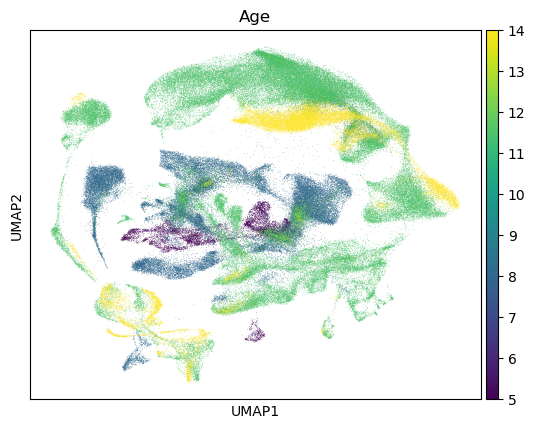

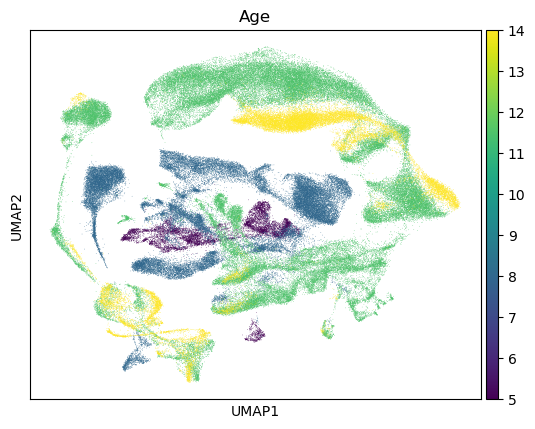

In [24]:
experiment_data.obs["Age"] = pd.to_numeric(experiment_data.obs["Age"])
sc.pl.umap(all_data, color=["condition"])
sc.pl.umap(experiment_data, color=["CellClass"])
sc.pl.umap(all_data, color=["CellClass"])
sc.pl.umap(ref_data, color=["CellClass"])
sc.pl.umap(experiment_data, color=["Age"])
sc.pl.umap(all_data, color=["Age"])
sc.pl.umap(ref_data, color=["Age"])

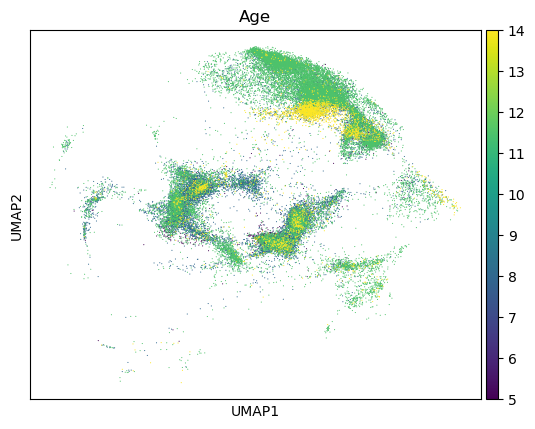

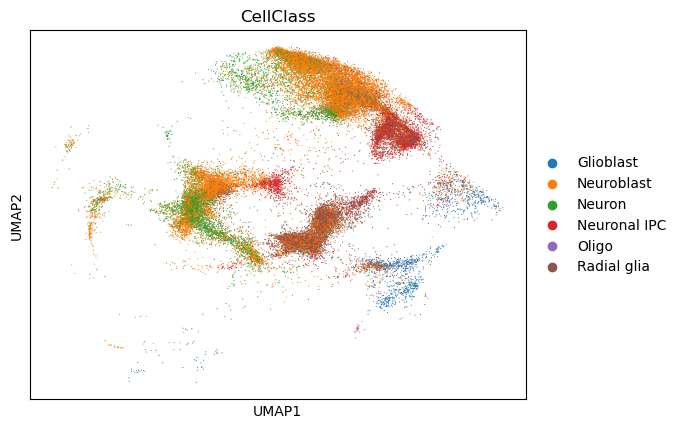

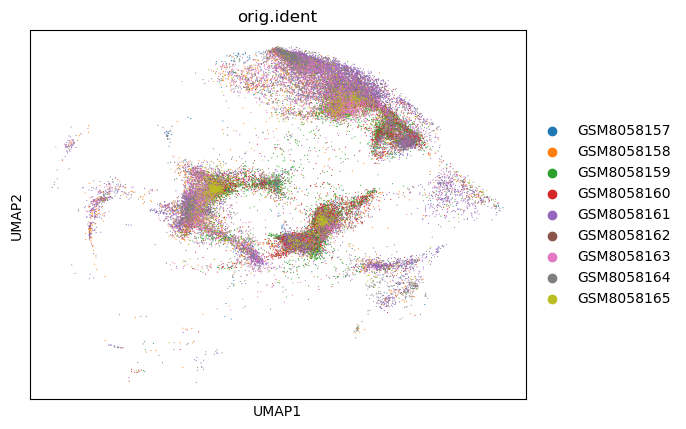

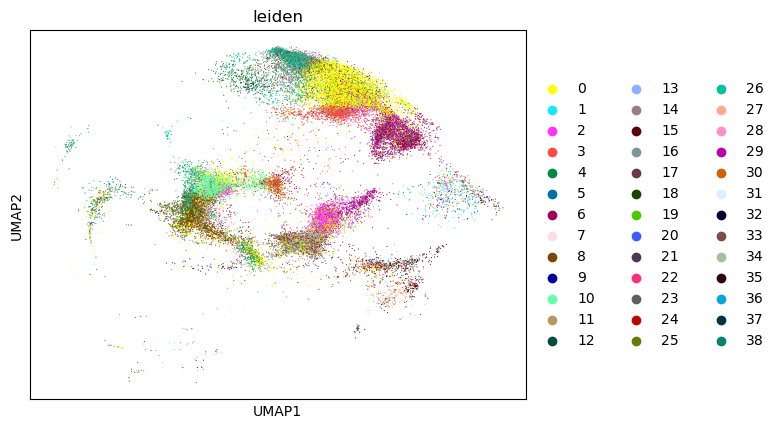

In [25]:
sc.pl.umap(experiment_data, color="Age")
sc.pl.umap(experiment_data, color="CellClass")
sc.pl.umap(experiment_data, color="orig.ident")
sc.pl.umap(experiment_data, color="leiden")



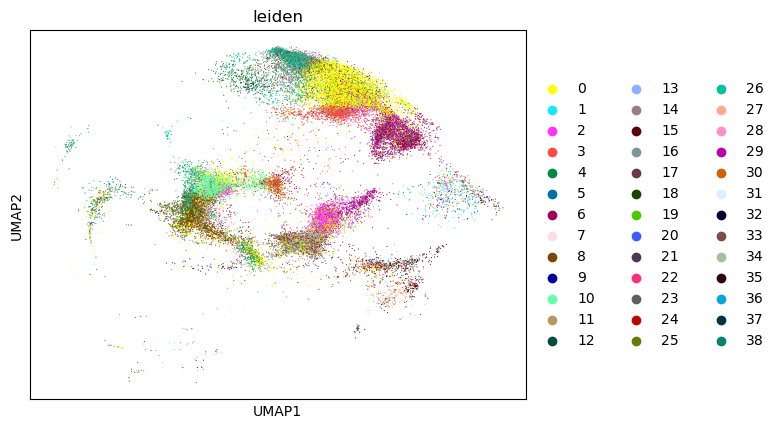

In [26]:
all_data.obs["leiden"] = (
    all_data.obs["leiden"].astype("category").cat.reorder_categories(ref_data.obs["leiden"].cat.categories)
)

sc.pl.umap(experiment_data, color="leiden")

# fix category colors


In [28]:

ref_data.write_h5ad("/home/sofia/Projects/etmr/de Faria/healthy/human_dev_cont_age_int.h5ad")
experiment_data.write_h5ad("/home/sofia/Projects/etmr/de Faria/snRNA/data/snrna_etmr_data_int.h5ad")
